In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import math
import quimb as qu
from pathlib import Path
from matplotlib.colors import LogNorm, Normalize

from itertools import product
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, CyclicLR, CosineAnnealingLR
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models import Lindbladian
from ml.classes import MLLP
from utils import print_comparison, print_comparison_3, print_omega, print_rates
from sfw.optimizers import Adam
from ml.core import train
from ml.utils import calculate_error

%load_ext autoreload
%autoreload 2

In [2]:
def print_data(tebd, exp, start, end, ylim, dt=0.01):
    t = np.arange(start*dt, end*dt, dt)[:-1]
        
    rows= 5
    columns = 3
    
    names = ['I1X2', 'I1Y2', 'I1Z2', 'X1I2', 'X1X2', 'X1Y2', 'X1Z2', 'Y1I2', 'Y1X2', 'Y1Y2', 'Y1Z2', 'Z1I2', 'Z1X2', 'Z1Y2', 'Z1Z2']

    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,(end-start)*dt), ylim=(-ylim, ylim))

    for i in range(rows):
        for j in range(columns):
            #if i == rows-1 & j == columns-1:
            #    continue
            #axs[i, j].plot(t, [tebd[k][columns*i+j] for k in range(len(t))], label='tebd')
            axs[i, j].plot(t, [exp[k][columns*i+j] for k in range(len(t))], label='exp')

            axs[i, j].grid()
            axs[i, j].set_title(names[columns*i+j], x=0.5, y=0.85)
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

In [3]:
def create_basis(spin_base):
    """Returns the basis F_i using spin operators in
        represented in the basis 'spin_base'.
        
    e.g. spin_base = 'zx'
    means the spin opertors for the first spin are
    represented in the z-basis, whereas the spin
    operators for the second spin are represented in
    the x-basis.
    """
    paulis = {'z' : {'I' : qu.pauli('I'),
                    'X' : qu.pauli('X'),
                    'Y' : qu.pauli('Y'),
                    'Z' : qu.pauli('Z')},
              'y' : {'I' : qu.pauli('I'),
                    'X' : qu.pauli('Y'),  # X -> Y
                    'Y' : qu.pauli('Z'),  # Y -> Z
                    'Z' : qu.pauli('X')}, # Z -> X
              'x' : {'I' : qu.pauli('I'),
                    'X' : qu.pauli('Z'),  # X -> Z
                    'Y' : -qu.pauli('Y'), # Y -> -Y
                    'Z' : qu.pauli('X')}, # Z -> X
             }
    # the pauli op. in the right basis
    pauli1 = paulis[spin_base[0]]
    pauli2 = paulis[spin_base[1]]
    
    # build the F basis
    F = []
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        F.append(0.5*pauli1[ob1]&pauli2[ob2])

    return F

In [4]:
def experimental_data(data, N):
    """The function reconstruct the rho, save the diagonal = probability.
    From the probability I can sample -> psi state.
    Having the state I can calculate the expecation value.
    
    Parameters
    ----------
    data : array
        1D array of tebd data len == 15
    N : int
        Number of samples to use
    
    """
    basis = ['xx', 'yy', 'zz', 'xy', 'xz', 'yx', 'yz', 'zx', 'zy']
    
    probability = {}
    for b in basis:
        F_b = create_basis(b)
        rho = np.matrix(np.eye(4, dtype=complex)/4) # the Identity
        for i in range(15):
            rho += data[i]*F_b[i+1]/2  # this /2 comes from the fact data in [-1, 1], NOT [-1/2, 1/2]
        probability[b] = np.asarray(rho.diagonal().real)[0]
            
    samples = {}
    for key in probability.keys():
        unique, counts = np.unique(np.random.choice([0,1,2,3], size=N, p=probability[key]), return_counts=True)

        samples[key] = [0, 0, 0, 0]
        for u, c in zip(unique, counts):
            samples[key][u] = c/N
            
    # I need the operator of which calculate the expecation value: either I or sigma Z bacause
    # I put myself always in the right basis
    # Ans the basis in which calculate the expecation value
    operator = ['IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']
    basis    = ['xx', 'yy', 'zz', 'xx', 'xx', 'xy', 'xz', 'yy', 'yx', 'yy', 'yz', 'zz', 'zx', 'zy', 'zz']
    pauli = {'I' : qu.pauli('I').real,
            'X' : qu.pauli('Z').real,
            'Y' : qu.pauli('Z').real,
            'Z' : qu.pauli('Z').real}

    exp_data = [0]*15
    for i in range(15):
        psi = samples[basis[i]]
        op = pauli[operator[i][0]]&pauli[operator[i][1]]
        exp_data[i] = (op@psi).sum()
        
    return np.array(exp_data)

In [5]:
def initial_conditions(F_base):
    '''Function returning a random density matrix. '''
    rho = qu.gen.rand.rand_rho(4)

    v_0 = np.array([np.trace(np.dot(f,rho)) for f in F_base]).real
    return v_0[1:]

# Create the data
The Lindbladian is 
$$H = \frac{\Omega}{2} ( \sigma_1^x + \sigma_2^x  ) + V n_1 n_2 $$
$$J^{(1)} =  \sqrt{\gamma} ( \sigma^{-}_1 + \sigma^{-}_2 ) $$
$$J^{(2)} =  \sqrt{k} ( n_1 + n_2 ) $$

In [6]:
class LindbladClass(Lindbladian):
    def __init__(self, V, gamma, kappa):
        super(LindbladClass, self).__init__()
        self.V = V 
        self.gamma = gamma
        self.kappa = kappa
    
    def kossakowski(self, t):
        s_1 = torch.zeros((15), dtype=torch.cfloat)
        s_2 = torch.zeros((15), dtype=torch.cfloat)

        s_1[0] = 2
        s_1[1] = -1j*2
        s_1[3] = 2
        s_1[7] = -1j*2
        
        s_2[2] = 1
        s_2[11] = 1
        
        koss = torch.einsum('i,j->ij', s_1, s_1.conj())*self.gamma
        koss += torch.einsum('i,j->ij', s_2, s_2.conj())*self.kappa
        return koss

    def omega(self, t):
        w = torch.zeros((15))
        w[0] = 1
        w[3] = 1
        w[2] = self.V/2
        w[11] = self.V/2
        w[14] = self.V/2
        
        return w

In [489]:
prms = {'model': 1,
        'V': 0.5,
        'gamma' : 0.01,
        'kappa' : 0.01,
        'T': 10,
        'T_test':40,
        'num_traj': 30,
        'N' : 60,       # number of samples for each time and i.c.
        'M' : 60        # number of times for each i.c.
       }

L1 = LindbladClass(prms['V'],prms['gamma'],prms['kappa'])
# base
F = create_basis('zz')

# Data Generation

In [490]:
### CREATE - training set
exp_data = {'X' : [],
            'y' : [],
            't' : []}
for n in range(prms['num_traj']):
    # first I create the exact dynamics
    v_0 = initial_conditions(F)
    results, t = L1.generate_trajectory(v_0=v_0, T=prms['T'])
    #exp_data['X'].append([v_0]*len(results))
    #exp_data['y'].append(results)
    #exp_data['t'].append(t)
    
    # select some random times at which to sample
    indeces = np.random.choice(range(1, len(results)), prms['M'], replace=False)
    for i in indeces:
        # same initial conditions and time
        exp_data['X'].append(v_0)
        exp_data['t'].append(t[i])
        # the data
        exp_data['y'].append( experimental_data(results[i], N=prms['N']))
        
### SAVE
gname = 'cohVec_model_' + str(prms['model']) + \
        '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
        '_N_' + str(int(prms['N'])) + '_M_' + str(int(prms['M']))

with h5py.File('./data/data_exact_L.hdf5', 'a') as f:
    # create the subgroup
    try:
        subg = f.create_group(gname)
    except:
        subg = f[gname]
        del f[gname+'/X']
        del f[gname+'/y']
        del f[gname+'/t']

    subg.create_dataset('X', data=exp_data['X'])
    subg.create_dataset('y', data=exp_data['y'])
    subg.create_dataset('t', data=exp_data['t'])

In [ ]:
### CREATE - test set X10
exp_data = {'y' : [],
            't' : []}

for i in range(10):
    v_0 = initial_conditions(F)
    results, t = L1.generate_trajectory(v_0=v_0, T=prms['T_test'])
    
    exp_data['y'].append( results )
    exp_data['t'].append( t )
        
### SAVE
gname = 'cohVec_model_' + str(prms['model'])

with h5py.File('./data/data_exact_L_test.hdf5', 'a') as f:
    # create the subgroup
    try:
        subg = f.create_group(gname)
    except:
        subg = f[gname]
        del f[gname+'/y']
        del f[gname+'/t']

    subg.create_dataset('y', data=exp_data['y'])
    subg.create_dataset('t', data=exp_data['t'])

In [ ]:
# plot
print_data(_, exp_data['y'], 0, 2000, ylim=1)

# Train the model

In [377]:
class CustomDatasetFromHDF5(Dataset):
    '''Class implementing the Dataset object, for
    the data, to the pass to DataLoader. It directly takes
    the data from the hdf5 file
    NOTE: here I also normalize the data respect to beta!

    Parameters
    ----------
    path : str
        Path to where hdf5 file is
    group : array of str
        Group name or names of the desired data
    T_train : int
        Max time to reach
    dt : float
        Time increment used in data generation
    num_traj : int
        Number of trajectories
    resize : bool
        To resize the dataset according to T_train
    '''

    def __init__(self, path, group, dt, num_traj):
        with h5py.File(path, 'r') as f:
            self.X = []
            self.y = []
            self.t = []
            self.V = [] # dummy vector

            self.X.extend(f[group + '/X'][()])
            self.y.extend(f[group + '/y'][()])
            self.t.extend(f[group + '/t'][()])
            self.V.extend([0]*len(f[group + '/X'][()]))

    def __getitem__(self, index):
        # return the potential and the vector at t and t+dt
        # as tensors
        return torch.tensor(self.V[index]), torch.tensor(self.t[index]), \
            torch.tensor(self.X[index]), torch.tensor(self.y[index])

    def __len__(self):
        return len(self.X)

In [11]:
def load_data(path, model, potential, N, M,
              num_traj, batch_size, validation_split):
    '''Function to load the NORMALIZED data from hdf5 file.
    Reshuffling of data is performed. Then separates train
    from validation and return the iterables.
    NOTE: this functions takes both beta and potential as arrays
    in case one wants to have wider training sets.

    Parameters
    ----------
    path : str
        Path to the hdf5 file
    T_train : int
        Time used in the training procedure
    num_traj : int
    validation_split : float
        Number 0 < .. < 1 which indicates the relative
        sizes of validation and train

    Return
    ------
    train and validation loaders
    '''

    # list of group names
    gname = 'cohVec_model_' + str(model) + \
            '_V_' + str(int(potential*1e3)).zfill(4) + \
            '_N_' + str(int(N)) + '_M_' + str(int(M))

    dataset = CustomDatasetFromHDF5(path, gname, 0.01, num_traj)

    # creating the indeces for training and validation split
    dataset_size = len(dataset)
    indeces = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    print(f"Data points used in the training {dataset_size}")

    # shuffling the datesets
    np.random.seed(42)
    np.random.shuffle(indeces)
    train_indices, val_indices = indeces[split:], indeces[:split]

    # Creating PT data samplers and loaders
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batch_size,
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             sampler=valid_sampler)
    return train_loader, val_loader

Data points used in the training 1800
= Starting epoch  1 / 400
=== Mean train loss: 0.033387209056
=== lr: 0.01000
= Starting epoch  2 / 400
=== Mean train loss: 0.028071850538
=== lr: 0.01000
= Starting epoch  3 / 400
=== Mean train loss: 0.027464588638
=== lr: 0.01000
= Starting epoch  4 / 400
=== Mean train loss: 0.027686895803
=== lr: 0.01000
= Starting epoch  5 / 400
=== Mean train loss: 0.026463156799
=== lr: 0.01000
= Starting epoch  6 / 400
=== Mean train loss: 0.026312361704
=== lr: 0.01000
= Starting epoch  7 / 400
=== Mean train loss: 0.025189360604
=== lr: 0.01000
= Starting epoch  8 / 400
=== Mean train loss: 0.026302695274
=== lr: 0.01000
= Starting epoch  9 / 400
=== Mean train loss: 0.025265767705
=== lr: 0.01000
= Starting epoch  10 / 400
=== Mean train loss: 0.025141871069
=== lr: 0.01000
= Starting epoch  11 / 400
=== Mean train loss: 0.025006755022
=== lr: 0.01000
= Starting epoch  12 / 400
=== Mean train loss: 0.024829875445
=== lr: 0.01000
= Starting epoch  13 / 

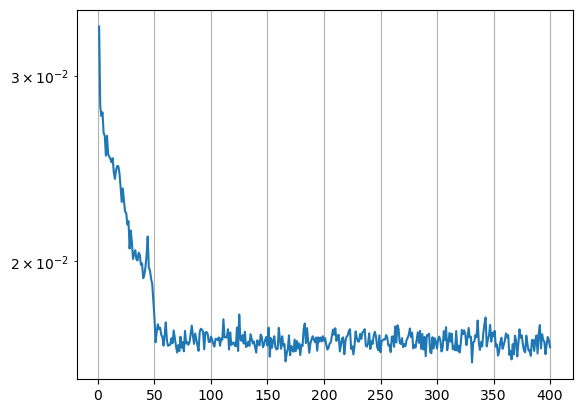

In [494]:
ml_params = {'model_dir': './data/trained_exact_L/',  # folder where the metadata of the training are stored
             'validation_split': 0,
             'batch_size': 256,
             'time_dependent': False,
             'n_epochs': 400,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt': 0.01
                 },
             }

# load the data
train_loader, eval_loader = load_data('./data/data_exact_L.hdf5', prms['model'],
                                      prms['V'], prms['N'], prms['M'], prms['num_traj'], 
                                      ml_params['batch_size'],
                                      ml_params['validation_split'])
# create the model
model = MLLP(ml_params['mlp_params'], potential=0,
             time_dependent=ml_params['time_dependent']).to(ml_params['device'])

criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)
#scheduler = ExponentialLR(optimizer, 0.99)
scheduler = MultiStepLR(optimizer, milestones=[350], gamma=0.1)
#scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-2, step_size_up=250, step_size_down=250, mode='triangular', cycle_momentum=False)

# train the model
loss = train(model, criterion, optimizer, scheduler, train_loader,
            ml_params['n_epochs'], ml_params['device'],
            epochs_to_prune=[], alpha_1=[1e-4, 0], alpha_2=[])

# name the model
name = 'model_' + str(prms['model']) + \
        '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
        '_N_' + str(int(prms['N'])) + '_M_' + str(int(prms['M']))
# save the model
torch.save(model.state_dict(), ml_params['model_dir'] + name)

plt.plot([i for i in range(1, ml_params['n_epochs']+1)], loss)
plt.yscale('log')
plt.grid()

# See preformance of the model

In [351]:
# import test data
gname = 'cohVec_model_' + str(prms['model']) 

with h5py.File('./data/data_exact_L_test.hdf5', 'r') as f:
    data_test = f[gname+'/y'][()]

In [495]:
# calculate the average error
errors = np.zeros(10)
for i in range(10):
    ml_dyn = model.generate_trajectory(v_0=np.array(data_test[i][0]), T=20)    
    errors[i] = calculate_error(results_ml=ml_dyn, results_tebd=data_test[i], T=20, dt=0.01)
print(errors.mean())

0.007072741678516724


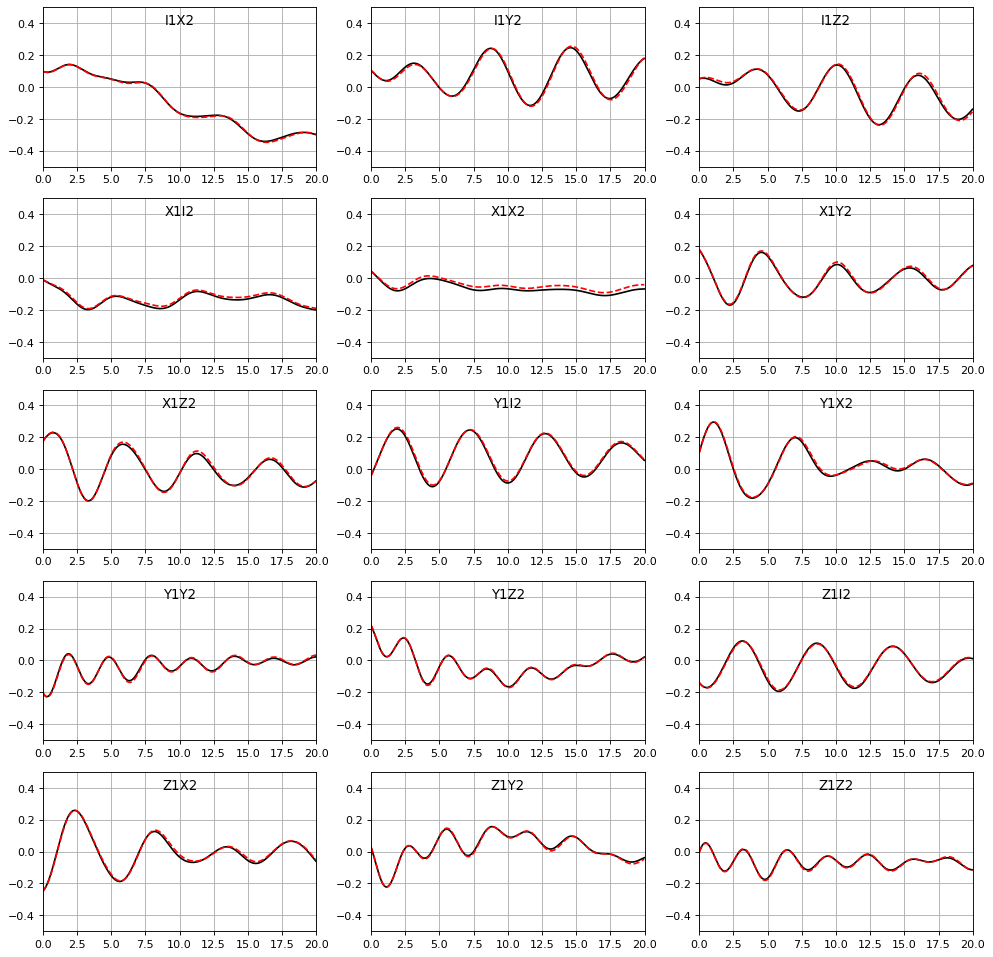

In [493]:
# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_test[4][0]), T=20)    
print_comparison(data_test[4], ml_dyn, 20, dt=0.01, ylim=0.5)

# Plot overall

In [483]:
# for each combinations of potential and L I calculate the error
N = [5,10,20,30,40,50]
M = [10,20,30,40,50,60]

errors = []

# import test data
gname = 'cohVec_model_' + str(prms['model']) 

with h5py.File('./data/data_exact_L_test.hdf5', 'r') as f:
    data_test = f[gname+'/y'][()]

for m in M:
    err = []
    for n in N:
        # import the model
        # name the model
        name = 'model_' + str(prms['model']) + \
            '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
            '_N_' + str(n) + '_M_' + str(m)

        model = MLLP(ml_params['mlp_params'], potential=0).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_exact_L/' + name)))
        
        # calculate error
        errs = np.zeros(10)
        for i in range(10):
            ml_dyn = model.generate_trajectory(v_0=np.array(data_test[i][0]), T=20)    
            errs[i] = calculate_error(results_ml=ml_dyn, results_tebd=data_test[i], T=20, dt=0.01)
    
        err.append(errs.mean())
    errors.append(err)

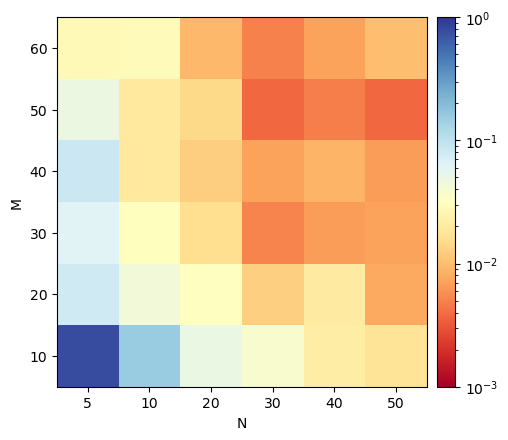

In [484]:
fig, ax = plt.subplots()

im = ax.imshow(errors, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = N
my_y_ticks = M
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('N')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel('M')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/length_dependance_W.pdf', dpi=150)

In [ ]:
# for each combinations of potential and L I calculate the error
N = 1
M = [500]

errors_2 = []

# import TEBD data
gname = 'cohVec_L_' + str(prms['L']) + \
        '_V_' + str(int(prms['potential']*1e3)).zfill(4) + \
        '_beta_' + str(int(prms['beta']*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
#print(gname)
with h5py.File('./data/data_unc_test.hdf5', 'r') as f:
    data_test = f[gname+'/X'][()]

for m in M:

    # import the model
    name = 'model_L_' + str(prms['L']) + \
        '_V_' + str(int(prms['potential']*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_N_' + str(N) + '_M_' + str(m)

    model = MLLP(ml_params['mlp_params'], potential=prms['potential']).to(ml_params['device'])
    model.load_state_dict(torch.load(Path('./data/trained_experimental/' + name)))

    # predict dynamics with the model
    ml_dyn = model.generate_trajectory(v_0=np.array(data_test[0]), T=20, beta=prms['beta'])

    # calculate error
    errors_2.append(calculate_error(results_ml=ml_dyn, results_tebd=data_test, T=20, dt=prms['dt']))

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(errors_2, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = N
my_y_ticks = M
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('N')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel('M')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/length_dependance_W.pdf', dpi=150)